# Ingesting image datasets for training with PyTorch

This example demonstrates how to work with image training datasets using [Ray Data](data) on a single node.

This example uses Ray Data to:
1. Load and preprocess raw images for training.
2. Load preprocessed images into PyTorch using [Ray Train](train) to train and validate an object classification model.


## Before You Begin

Install the following dependencies if you haven't already.

In [1]:
!pip install "ray[data]" torchvision awscli

First download an image dataset to use. If you already have an image dataset on local disk or in S3, you can skip the rest of this section.
Otherwise, follow on to download a dataset from Kaggle.
This example, uses bash to download a [4GB subset of the ImageNet dataset](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000) and (optionally) upload it to an S3 bucket.

```bash
$ pip install kaggle awscli
$ kaggle datasets list -s ifigotin/imagenetmini-1000
# ref                         title                 size  lastUpdated          downloadCount  voteCount  usabilityRating  
# --------------------------  --------------------  ----  -------------------  -------------  ---------  ---------------  
# ifigotin/imagenetmini-1000  ImageNet 1000 (mini)   4GB  2020-03-10 01:05:11          11779        133  0.375
$ kaggle datasets download ifigotin/imagenetmini-1000
$ unzip imagenetmini-1000.zip -d /tmp
```

The directory structure should look like this:
```bash
$ tree /tmp/imagenet-mini
# ── train
# │   ├── n01440764
# │   │   ├── n01440764_10043.JPEG
# │   │   ├── n01440764_10470.JPEG
# │   │   ├── n01440764_10744.JPEG
# ...
# └── val
#     ├── n01440764
#     │   ├── ILSVRC2012_val_00009111.JPEG
#     │   ├── ILSVRC2012_val_00030740.JPEG
# ...
```

If you want to read from S3, run the following commands and pass the S3 URI `s3://imagenetmini-1000/train` in the following Python code.
Otherwise, you can pass the local path `/tmp/imagenet-mini/train`.
```bash
$ aws s3 mb s3://imagenetmini-1000
$ aws s3 sync /tmp/imagenet-mini s3://imagenetmini-1000
$ aws s3 ls s3://imagenetmini-1000/train/
#                           PRE n01440764/
#                           PRE n01443537/
#                           PRE n01484850/
#                           ...
```

## Loading the training dataset

Start by loading the training dataset and examining the data.
To speed things up, first download the dataset from S3 to local disk.
If you're using a multi-node cluster, you can also just read directly from S3.


In [ ]:
! aws s3 sync s3://imagenetmini-1000/ /tmp/imagenetmini-1000

You can use {meth}`~ray.data.Dataset.take_batch` to produce a single batch of data.
A later step applies preprocessing transforms to the images, one batch at a time.

Snapshotting files: 100%|██████████| 16/16 [00:00<00:00, 338.41file/s]
2023-08-03 13:11:02,107	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 10.0.31.76:6379...
2023-08-03 13:11:02,114	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at https://session-7cps2wj2bpr5nk4lkq78s6ju58.i.anyscaleuserdata-staging.com 
2023-08-03 13:11:02,145	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_0824cd59808afa94e592db89e239bc80.zip' (9.52MiB) to Ray cluster...
2023-08-03 13:11:02,170	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_0824cd59808afa94e592db89e239bc80.zip'.
2023-08-03 13:11:11,532	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage]
2023-08-03 13:11:11,533	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

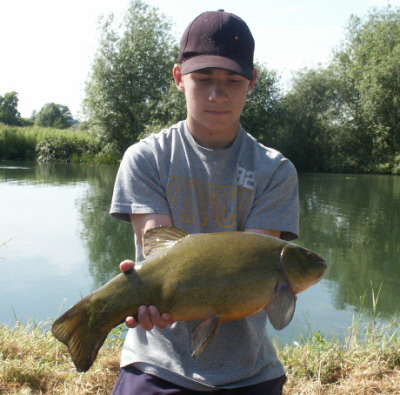

In [3]:
import ray
from PIL import Image


TRAIN_DATASET_URL = "/tmp/imagenetmini-1000/train"

# Uncomment to read directly from S3.
# This approach is recommended if you are using multiple nodes for training
# or if you do not have enough disk space to hold the entire dataset.
# TRAIN_DATASET_URL = "s3://imagenetmini-1000/train"

ds = ray.data.read_images(TRAIN_DATASET_URL, mode="RGB")

batch = ds.take_batch(batch_size=2)
print(batch)
# {'image': array([array([[[110, 117, 123],
#                [111, 118, 124],
#                [113, 118, 124],
#                ...,
#                [164, 191, 210]]], dtype=uint8)], dtype=object)}

def show(image_array):
    image = Image.fromarray(image_array)
    display(image)    

show(batch["image"][0])

When you pass the `Dataset` to Ray Train, you receive a {class}`ray.data.DataIterator` on each training worker.
Use that API to iterate through the dataset.
Limit the dataset to 1000 rows to shorten the execution and use {meth}`ray.data.DataIterator.iter_torch_batches` since you are using a PyTorch model later on.

Try commenting back in the code below and see what happens.

In [4]:
# This is the interface that Ray Train workers use.
it = ds.limit(1000).iterator()

# for torch_batch in it.iter_torch_batches(batch_size=32):
#     print(torch_batch)

Did you get an error above?

You should have seen an error like this output:
```python
RuntimeError: Numpy array of object dtype cannot be converted to a Torch Tensor. This may because the numpy array is a ragged tensor--it contains items of different sizes. If using `iter_torch_batches()` API, you can pass in a `collate_fn` argument to specify custom logic to convert the Numpy array batch to a Torch tensor batch.
```

This error happens because each of the images is a different size. In a later step, when you crop all of the images to the same size, you can revisit the sizing.

## Extracting labels from the pathname

You also want the dataset to include the label for each image.
For images where the subdirectory name is also the class name, use a {class}`~ray.data.datasource.Partitioning` to extract the class name from each filename and attach it as an additional field to each row.

In [5]:
from ray.data.datasource.partitioning import Partitioning

ds = ray.data.read_images(TRAIN_DATASET_URL, mode="RGB", partitioning=Partitioning("dir", field_names=["class"], base_dir=TRAIN_DATASET_URL))
batch = ds.take_batch(batch_size=2)
print(batch["class"])
# ['n01608432' 'n01608432']

2023-08-03 13:11:13,729	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage]
2023-08-03 13:11:13,731	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-03 13:11:13,732	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

['n01440764' 'n01440764']


If you have a different directory structure, you can attach each image's filename using `include_paths=True` and add a custom {meth}`~ray.data.Dataset.map_batches` call to extract the class label instead.

In [6]:
from ray.data.datasource.partitioning import Partitioning
import os

ds = ray.data.read_images(TRAIN_DATASET_URL, mode="RGB", include_paths=True)
batch = ds.take_batch(batch_size=2)
print(batch["path"])
# array(['/tmp/imagenet-mini/train/n01560419/n01560419_2363.JPEG',
#        '/tmp/imagenet-mini/train/n01560419/n01560419_2368.JPEG'],
#       dtype=object)

def extract_class_from_basename(batch):
    batch["class"] = [os.path.basename(path).split("_")[0] for path in batch["path"]]
    return batch

ds = ds.map_batches(extract_class_from_basename)
batch = ds.take_batch(batch_size=2)
print(batch["class"])
# array(['n01530575', 'n01530575'], dtype=object)

2023-08-03 13:11:16,087	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage]
2023-08-03 13:11:16,088	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-03 13:11:16,088	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-08-03 13:11:19,330	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(extract_class_from_basename)]
2023-08-03 13:11:19,331	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-03 13:11:19,331	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


['/tmp/imagenetmini-1000/train/n01440764/n01440764_10043.JPEG'
 '/tmp/imagenetmini-1000/train/n01440764/n01440764_10470.JPEG']


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

['n01440764' 'n01440764']


(ReadImage->MapBatches(extract_class_from_basename) pid=205472) Traceback (most recent call last):
(ReadImage->MapBatches(extract_class_from_basename) pid=205472)   File "pyarrow/public-api.pxi", line 124, in pyarrow.lib.pyarrow_wrap_data_type
(ReadImage->MapBatches(extract_class_from_basename) pid=205472)   File "pyarrow/types.pxi", line 452, in pyarrow.lib.StructType.init
(ReadImage->MapBatches(extract_class_from_basename) pid=205472)   File "pyarrow/types.pxi", line 142, in pyarrow.lib.DataType.init
(ReadImage->MapBatches(extract_class_from_basename) pid=205472)   File "pyarrow/types.pxi", line 76, in pyarrow.lib._datatype_to_pep3118
(ReadImage->MapBatches(extract_class_from_basename) pid=205472)   File "pyarrow/types.pxi", line 1021, in pyarrow.lib.PyExtensionType.__arrow_ext_deserialize__
(ReadImage->MapBatches(extract_class_from_basename) pid=205472)   File "/home/ray/anaconda3/lib/python3.9/site-packages/ray/air/util/tensor_extensions/arrow.py", line 543, in __init__
(ReadImage-

To extract the class as an integer, you can do another `map_batches` call to convert the string to an integer.

If your class names don't already have an integer in them, you can also assign each class name an integer. To do this, first call {meth}`~ray.data.Dataset.unique` to get the unique label values and assign each value an integer.

In [7]:
ds = ray.data.read_images(TRAIN_DATASET_URL, mode="RGB", partitioning=Partitioning("dir", field_names=["class"], base_dir=TRAIN_DATASET_URL))
# Create a dict mapping from class_name -> integer.
classes = ds.unique(column="class")
classes_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

2023-08-03 13:11:22,627	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-08-03 13:11:22,628	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-03 13:11:22,628	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/200 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/200 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/200 [00:00<?, ?it/s]

Next, call `map_batches` again to convert each image's class from a string to an integer.

In [8]:
# Convert the string class names to integers in the dataset.
def convert_class_to_idx(batch, classes_to_idx):
    batch["class"] = [classes_to_idx[class_name] for class_name in batch["class"]]
    return batch

ds = ray.data.read_images(TRAIN_DATASET_URL, mode="RGB", partitioning=Partitioning("dir", field_names=["class"], base_dir=TRAIN_DATASET_URL))
ds = ds.map_batches(convert_class_to_idx, fn_kwargs={"classes_to_idx": classes_to_idx})
batch = ds.take_batch(batch_size=2)
print(batch["class"])
# [0 0]

2023-08-03 13:11:50,980	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(convert_class_to_idx)]
2023-08-03 13:11:50,981	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-03 13:11:50,982	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

[0 0]


## Preprocessing images

Next apply some preprocessing transforms to the images.
Use [torchvision](https://pytorch.org/vision/stable/index.html) to define a preprocessor function that randomly crops and flips a batch of images, then returns the image as a `torch.Tensor`.
This code matches the spec for the [MLPerf image classification benchmark](https://github.com/mlcommons/training/tree/master/image_classification).

In [9]:
import torch
import torchvision
import numpy as np

DEFAULT_IMAGE_SIZE = 224

def crop_and_flip_image_batch(image_batch):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(
                size=DEFAULT_IMAGE_SIZE,
                scale=(0.5, 1.0),
                ratio=(0.75, 1.33),
            ),
            torchvision.transforms.RandomHorizontalFlip(),
        ]
    )
    
    # Tip: Use ray.data.read_images(size=(H, W)) to resize all images
    # during loading. Then, you can use vectorized transforms here,
    # shown below, instead of applying the transform one image at a time.
    # tensor_batch = torch.Tensor(np.transpose(image_batch["batch"], axes=(0, 3, 1, 2))
    # image_batch["image"] = transform(tensor_batch)

    def crop_and_flip_image(image):
        # Transpose to match torchvision's expected shape.
        # (height, width, channels) -> (channels, height, width).
        return transform(torch.Tensor(np.transpose(image, axes=(2, 0, 1))))
    
    image_batch["image"] = [crop_and_flip_image(image) for image in image_batch["image"]]
    return image_batch

First, try the function out manually on one of the batches that you produced earlier.

In [ ]:
import numpy as np

print("Before")
batch = ds.take_batch(batch_size=2)
show(batch["image"][0])

batch = crop_and_flip_image_batch(batch)
print("After")
cropped_and_flipped_img = np.transpose(
    np.array(batch["image"][0], dtype=np.uint8),
    axes=(1, 2, 0))
show(cropped_and_flipped_img)

Now apply the preprocessor to the entire dataset.

In [10]:
def get_training_dataset(url):
    ds = ray.data.read_images(url, mode="RGB", partitioning=Partitioning("dir", field_names=["class"], base_dir=url))
    ds = ds.map_batches(convert_class_to_idx, fn_kwargs={"classes_to_idx": classes_to_idx})
    ds = ds.map_batches(crop_and_flip_image_batch)
    return ds

Now that all of the images have the same dimensions, you're ready to iterate using {meth}`ray.data.DataIterator.iter_torch_batches`.

Note that because you're using a randomized preprocessor, each time you call `DataIterator.iter_torch_batches`, it produces different results.
This behavior can be helpful during training, if you want to randomly apply transforms during each epoch.

In [11]:
# This is the interface that Ray Train workers use.
ds = get_training_dataset(TRAIN_DATASET_URL)
it = ds.limit(1000).iterator()

num_rows_read = 0
for torch_batch in it.iter_torch_batches(batch_size=32):
    num_rows_read += len(torch_batch["image"])
print(f"Read {num_rows_read} rows.")

2023-08-03 13:11:55,590	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(convert_class_to_idx)->MapBatches(crop_and_flip_image_batch)] -> LimitOperator[limit=1000]
2023-08-03 13:11:55,591	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-03 13:11:55,592	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read 1000 rows.


## Training a model on the dataset

Now you're ready to build an end-to-end example.
First, define the code for the training worker.
This code uses the {class}`ray.data.DataIterator` that you defined earlier to load batches of data into a training worker.

In [26]:
import torch
from torchvision import models

from ray.air import Checkpoint
from ray.air import session


def train_one_epoch(*, model, criterion, optimizer, batch_size, epoch):
    model.train()

    device = ray.train.torch.get_device()
    # ray.air.session.get_dataset_shard returns a ray.data.DataIterator.
    it = session.get_dataset_shard("train")

    # Get an iterator of torch batches.
    # Since our preprocessor is randomized, this will return different
    # images on each epoch.
    batch_it = it.iter_torch_batches(
        batch_size=batch_size,
        # Passing device will place the batch on the same device as the model.
        device=device,
    )
    for batch in batch_it:
        outputs = model(batch["image"])
        loss = criterion(outputs, batch["class"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        session.report(
            {
                "losses": loss.item(),
                "epoch": epoch,
                "lr": optimizer.param_groups[0]["lr"],
            }
        )


def train_func(config):
    model = models.resnet50()
    model = ray.train.torch.prepare_model(model)
    parameters = [p for p in model.parameters() if p.requires_grad]
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        parameters,
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"],
    )

    for epoch in range(0, config["epochs"]):
        train_one_epoch(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            batch_size=config["batch_size"],
            epoch=epoch,
        )
        checkpoint = Checkpoint.from_dict(
            {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "config": config,
                "epoch": epoch,
            }
        )
        session.report({}, checkpoint=checkpoint)

Next, run the training loop.
Define the training dataset (limit it to a smaller number of rows) and pass it to the {class}`ray.train.torch.TorchTrainer`.
If you're using multiple training workers, Ray Train splits the dataset into one iterator per training worker, and each worker sees a disjoint subset of the data.
But for now, just use 1 training worker and a CPU model.

In [29]:
from ray.air.config import DatasetConfig, ScalingConfig
from ray.train.torch import TorchTrainer

# Limit to 32 images to reduce execution time.
train_dataset = get_training_dataset(TRAIN_DATASET_URL).limit(32)

trainer = TorchTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 4,
        "lr": 0.02,
        "epochs": 1,
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "lr_steps": [16, 22],
        "lr_gamma": 0.1,
    },
    # Uncomment this line if you are ready to test on a GPU(s).
    # scaling_config=ScalingConfig(num_workers=1, use_gpu=True),
    scaling_config=ScalingConfig(num_workers=1),
    datasets={"train": train_dataset},
)
results = trainer.fit()

(TorchTrainer pid=239034) Starting distributed worker processes: ['239100 (10.0.31.76)']
(RayTrainWorker pid=239100) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=239100) Moving model to device: cpu
(SplitCoordinator pid=239162) Auto configuring locality_with_output=['a9c0a88e2351d91d6df81630e5435f35a66399f6f8318c21b6b39d1f']
(SplitCoordinator pid=239162) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(convert_class_to_idx)->MapBatches(crop_and_flip_image_batch)] -> LimitOperator[limit=32] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=239162) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['a9c0a88e2351d91d6df81630e5435f35a66399f6f8318c21b6b39d1f'], preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=239162) Tip: For detailed progress reporting, run `ray.data.Da

(pid=239162) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2023-08-03 13:43:57,702	INFO tune.py:1145 -- Total run time: 89.69 seconds (89.64 seconds for the tuning loop).


Check the results of the training job.

First, define a validation dataset. This validation dataset looks very similar to the training dataset, but it doesn't have the random transforms.

In [75]:
VALIDATION_DATASET_URL = "s3://imagenetmini-1000/val"

def get_validation_dataset(url):
    # This is the same as get_training_dataset, except:
    # - we don't convert the classnames to integers
    # - we size the image to the correct size upon loading
    # - we don't apply the randomized transform
    ds = ray.data.read_images(url,
                              mode="RGB",
                              partitioning=Partitioning("dir", field_names=["class"], base_dir=url),
                              size=(DEFAULT_IMAGE_SIZE, DEFAULT_IMAGE_SIZE))
    def preprocess(batch):
        batch["image"] = np.transpose(batch["image"], axes=(0, 3, 1, 2)).astype(np.float32)
        return batch

    ds = ds.map_batches(preprocess)
    return ds

Next define a `Predict` class that you can use to load a copy of the model and make predictions on batches of the validation dataset.

In [79]:
from ray.train.torch import TorchPredictor
from ray.air import Checkpoint
from ray.data import ActorPoolStrategy


class Predict:

    def __init__(self, checkpoint: Checkpoint, idx_to_classes, k):
        self.predictor = TorchPredictor.from_checkpoint(checkpoint, model=models.resnet50())
        self.idx_to_classes = idx_to_classes
        self.k = k

    def __call__(self, batch):
        predictions = self.predictor.predict(batch["image"])["predictions"]
        top_k_idx = np.argsort(predictions, axis=1)[:, :-self.k:-1]
        top_k_classes = np.vectorize(lambda x: self.idx_to_classes.get(x, None))(top_k_idx)
        top_k_scores = np.take_along_axis(predictions, top_k_idx, axis=1)
        return {
            "class": batch["class"],
            "predictions": top_k_classes,
            "scores": top_k_scores,
        }

Finally, use `ray.data` to run batch prediction.

In [81]:
# Reverse mapping from integer label to the original class label.
idx_to_classes = {idx: classname for classname, idx in classes_to_idx.items()}

    
def predict(result: ray.air.Result):
    val_dataset = get_validation_dataset(VALIDATION_DATASET_URL).limit(4)

    predictions = val_dataset.map_batches(
        Predict, 
        fn_constructor_args=[result.checkpoint, idx_to_classes, 3],
        compute=ActorPoolStrategy(),
    )
    predictions.show()

predict(results)

2023-08-03 14:51:12,288	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(preprocess)] -> LimitOperator[limit=4] -> ActorPoolMapOperator[MapBatches(Predict)]
2023-08-03 14:51:12,288	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-03 14:51:12,289	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-03 14:51:13,614	INFO actor_pool_map_operator.py:121 -- MapBatches(Predict): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'class': 'n01440764', 'predictions': array(['n01631663', 'n03976467'], dtype='<U9'), 'scores': array([34307360.  ,   301012.75], dtype=float32)}
{'class': 'n01440764', 'predictions': array(['n01631663', 'n03976467'], dtype='<U9'), 'scores': array([25586710.  ,   215840.05], dtype=float32)}
{'class': 'n01440764', 'predictions': array(['n01631663', 'n03976467'], dtype='<U9'), 'scores': array([21906424.  ,   181899.16], dtype=float32)}
{'class': 'n01443537', 'predictions': array(['n01631663', 'n03976467'], dtype='<U9'), 'scores': array([27050254.  ,   226624.73], dtype=float32)}


## What next?

Now that ingest works on a single node, see [Ray AIR ingest guide](air-ingest) for more advanced features including:
- Scaling out to multiple GPU workers
- Configuring Datasets for shuffling data
- Improving Datasets performance